In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torchvision.models.segmentation import deeplabv3_resnet50

from PIL import Image
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

In [128]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
import torch.nn as nn
import torch.optim as optim
import multiprocessing
from torch.utils.data import DataLoader

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, out_channels, kernel_size=2, stride=2)
        )
        
    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        return x2


# Paths
dataset_dir = "../data/pascal_voc_dataset/VOCdevkit/VOC2012/JPEGImages"
train_dir = "../data/pascal_voc_dataset/train"
val_dir = "../data/pascal_voc_dataset/validation"
test_dir = "../data/pascal_voc_dataset/test"
mask_dir = "../data/pascal_voc_dataset/VOCdevkit/VOC2012/mask"


# Transforms to input images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Normalize tensor using mean and std
def normalize_tensor(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return (tensor - mean) / std

# Transforms to target masks
mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    normalize_tensor,
])

# Download and load the PASCAL VOC dataset
train_set = VOCSegmentation(root=train_dir, year='2012', image_set='train', download=True, transform=transform, target_transform=mask_transform)
val_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
test_set = val_set

# Split dataset
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)


in_channels = 3
out_channels = 3
model = UNet(in_channels, out_channels)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the number of CPU cores to use
num_cpu = multiprocessing.cpu_count()

print(f"Device in use: {device}")

# Move the model to the device
model = model.to(device)

# Wrap the model with DataParallel if multiple GPUs or CPUs are available
if torch.cuda.device_count() >= 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(model)
elif num_cpu > 1:
    print(f"Using {num_cpu} CPU cores.")
    model = nn.DataParallel(model)
else:
    print("Using single CPU.")
    
# Set the model to training mode
model.train()

# Checkpoint
current_checkpoint = 0

# Number of epochs
num_epochs = 20

# Define the average loss list
average_loss = []

# Training loop
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    for images, masks in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1, position=0):
        # Move data to the device
        images = images.to(device)
        masks = masks.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        #outputs = model(images)['out']
        outputs = model(images)

        # Calculate the loss
        #loss = criterion(outputs, masks.squeeze(1).long())
        #loss = criterion(outputs, masks.unsqueeze(1).float().squeeze(2))
        loss = criterion(outputs, masks.float())


        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for the given epoch
    average_loss.append(running_loss / len(train_loader))
    # saving every 10 epochs
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"n_modelo_{current_checkpoint+epoch}.pth")
        print(f"Model saved: modelo_{current_checkpoint+epoch}.pth")
    
print("Finished Training")

Using downloaded and verified file: ../data/pascal_voc_dataset/train/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/train/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/train
Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation
Device in use: cuda
Using 1 GPUs.


Epoch 10/20: 100%|██████████| 183/183 [00:26<00:00,  6.79it/s]


Model saved: modelo_10.pth


Epoch 20/20: 100%|██████████| 183/183 [00:27<00:00,  6.62it/s]

Model saved: modelo_20.pth
Finished Training


## Functions to better organize the pipeline
- `training_loop`: train the model
- `set_test`: test the model
- `load_unet_model`: load saved model checkpoints
- `test_predicted_image`: display image, predicted mask and ground truth mask
- `calculate_metrics`: calculate accuracy and IoU
- `update_average_loss`: update the average loss dictionary
- `calculate_f1_score`: calculate the F1 score

### Training loop

In [153]:
def training_loop(model, current_checkpoint: int, num_epochs: int,
                  train_loader: DataLoader, criterion, optimizer: optim.Optimizer):
    """ Training loop. """
    
    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Set the number of CPU cores to use
    num_cpu = multiprocessing.cpu_count()

    print(f"Device in use: {device}")

    # Move the model to the device
    model = model.to(device)

    # Wrap the model with DataParallel if multiple GPUs or CPUs are available
    if torch.cuda.device_count() >= 1:
        print(f"Using {torch.cuda.device_count()} GPUs.")
        model = nn.DataParallel(model)
    elif num_cpu > 1:
        print(f"Using {num_cpu} CPU cores.")
        model = nn.DataParallel(model)
    else:
        print("Using single CPU.")
        
    # Set the model to training mode
    model.train()

    # Define the average loss list
    average_loss = []
    
    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        for images, masks in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1, position=0):
            # Move data to the device
            images = images.to(device)
            masks = masks.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            #outputs = model(images)['out']
            outputs = model(images)

            # Calculate the loss
            loss = criterion(outputs, masks.float())


            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Print the average loss for the given epoch
        average_loss.append(running_loss / len(train_loader))
        # saving every 10 epochs
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"n_modelo_{current_checkpoint+epoch}.pth")
            print(f"Model saved: modelo_{current_checkpoint+epoch}.pth")
        
    print("Finished Training")

### Load UNet model from a given checkpoint

In [129]:
def load_unet_model(in_channels: int, out_channels: int, current_checkpoint: int):
    """ Load a UNet model from a checkpoint """
    model = UNet(in_channels, out_channels)
    state_dict = model.state_dict()

    checkpoint = torch.load(f'n_modelo_{current_checkpoint}.pth')
    avoid = [] #['fc.weight', 'fc.bias']
    for key in checkpoint.keys():
        if key in avoid or key not in state_dict.keys():
            continue
        if checkpoint[key].size() != state_dict[key].size():
            continue
        state_dict[key] = checkpoint[key]
    model.load_state_dict(state_dict)
    return model

### Update the average loss dictionary

In [131]:
def update_average_loss(avg_loss, average_loss):
    avg_loss.extend(average_loss)
    plt.plot(avg_loss)
    return avg_loss

### Set test

In [292]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import Subset
from tqdm import tqdm

def set_test(model, current_checkpoint: int):
    """ Set test data and test loader then perform the test. """

    val_dir = "../data/pascal_voc_dataset/validation"
    test_dir = "../data/pascal_voc_dataset/test"

    # Transforms to input images
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Normalize tensor using mean and std
    def normalize_tensor(tensor):
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        return (tensor - mean) / std

    # Transforms to target masks
    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        normalize_tensor,
    ])

    test_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
    test_set = Subset(test_set, range(1100))

    test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    num_cpu = multiprocessing.cpu_count()
    
    if torch.cuda.device_count() >= 1:
        print(f"Using {torch.cuda.device_count()} GPUs.")
        print(f"Using {num_cpu} CPU cores.")
    elif num_cpu > 1:
        print(f"Using {num_cpu} CPU cores.")
    else:
        print("Using single CPU.")

    model = model.to(device)

    for i, (images, masks) in enumerate(tqdm(test_loader), start=1):
        with torch.no_grad():
            images = images.to(device)
            outputs = model(images)
            
        # Save each prediction as separate files using torch.save()
        torch.save(images.cpu(), f'../rsc/test/image_{i}.pth')
        torch.save(outputs.cpu(), f'../rsc/ntest{current_checkpoint}/output_{i}.pth')
        torch.save(masks, f'../rsc/test/mask_{i}.pth')

    print("Test finished.")
    
    # TODO: (by TG) modify this to return the test_loader size instead of the test_loader itself
    
    return test_loader

### Display the image, output and mask

In [142]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def test_predicted_image(index: int, checkpoint: int):
    """ Display the image, ground truth mask, and predicted mask. """
    
    image = torch.load(f'../rsc/test/image_{index}.pth')
    output = torch.load(f'../rsc/ntest{checkpoint}/output_{index}.pth')
    mask = torch.load(f'../rsc/test/mask_{index}.pth')

    image.shape, output.shape, mask.shape

    # Select a specific image from the batch (e.g., the first image)
    image_single = image[0]
    output_single = output[0].argmax(dim=0, keepdim=True)
    mask_single = mask[0]

    # Scale the output and mask tensors to the range [0, 255]
    output_single_scaled = (output_single * 255).to(torch.uint8)
    mask_single_scaled = (mask_single * 255).to(torch.uint8)

    # Convert the single image and scaled tensors to PIL images
    image_pil = transforms.ToPILImage()(image_single.cpu())
    output_pil = transforms.ToPILImage()(output_single_scaled.cpu().squeeze())
    mask_pil = transforms.ToPILImage()(mask_single_scaled.cpu().squeeze())

    # Create a grid of subplots
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    # Plot the images in the subplots
    axes[0].imshow(image_pil)
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(output_pil)
    axes[1].set_title('Output')
    axes[1].axis('off')

    axes[2].imshow(mask_pil)
    axes[2].set_title('Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

### F1 score

In [315]:
def calculate_f1_score(checkpoint: int):
    
    print(f"Calculating F1 score for checkpoint {checkpoint}...")
    f1_scores = {}
    for i in tqdm(range(1, len(test_loader) + 1)):
        outputs = torch.load(f'../rsc/ntest{checkpoint}/output_{i}.pth')
        masks = torch.load(f'../rsc/test/mask_{i}.pth')

        # Move tensors to the same device
        device = outputs.device
        masks = masks.to(device)

        true_positives = torch.logical_and(outputs, masks).sum().item()
        false_positives = torch.logical_and(outputs, torch.logical_not(masks)).sum().item()
        false_negatives = torch.logical_and(torch.logical_not(outputs), masks).sum().item()

        precision = true_positives / (true_positives + false_positives)
        recall = true_positives / (true_positives + false_negatives)

        f1_score = 2 * (precision * recall) / (precision + recall)
        f1_scores[i] = f1_score

    print(f"\nAverage F1 Score: {sum(f1_scores.values()) / len(f1_scores)}\n")
    
    return f1_scores

### Accuracy and Iou

In [316]:
import torch
from tqdm import tqdm

def calculate_accuracy(outputs, masks):
    predicted_labels = torch.argmax(outputs, dim=1)
    true_labels = masks.argmax(dim=1)
    accuracy = (predicted_labels == true_labels).float().mean()
    return accuracy

def calculate_iou(outputs, masks):
    outputs = torch.argmax(outputs, dim=1)
    masks = masks.argmax(dim=1)
    
    intersection = torch.logical_and(outputs, masks).sum().item()
    union = torch.logical_or(outputs, masks).sum().item()
    
    iou = intersection / union
    return iou

def calculate_average_metrics(checkpoint: int, test_loader: DataLoader):
    
    print(f"Calculating IoU and accuracy for checkpoint {checkpoint}...")
    iou_scores = {}
    accuracy_scores = {}
    
    for i in tqdm(range(1, len(test_loader)+1)):
        outputs = torch.load(f'../rsc/ntest{checkpoint}/output_{i}.pth')
        masks = torch.load(f'../rsc/test/mask_{i}.pth')

        # Calculate IoU score
        iou = calculate_iou(outputs, masks)
        iou_scores[i] = iou

        # Calculate accuracy
        accuracy = calculate_accuracy(outputs, masks)
        accuracy_scores[i] = accuracy

    average_iou = sum(iou_scores.values()) / len(iou_scores)
    average_accuracy = sum(accuracy_scores.values()) / len(accuracy_scores)

    print(f"\nAverage IoU: {average_iou}")
    print(f"Average Accuracy: {average_accuracy}\n")
    
    return iou_scores, accuracy_scores


### Iou

In [285]:
def calculate_average_iou(checkpoint: int, test_loader: DataLoader):
    iou_scores = {}
    
    for i in tqdm(range(1, len(test_loader)+1)):
        outputs = torch.load(f'../rsc/ntest{checkpoint}/output_{i}.pth')
        masks = torch.load(f'../rsc/test/mask_{i}.pth')

        # Calculate IoU score
        iou = calculate_iou(outputs, masks)
        iou_scores[i] = iou     

    average_iou = sum(iou_scores.values()) / len(iou_scores)
    print("\nAverage IoU:", average_iou)
    
    return iou_scores

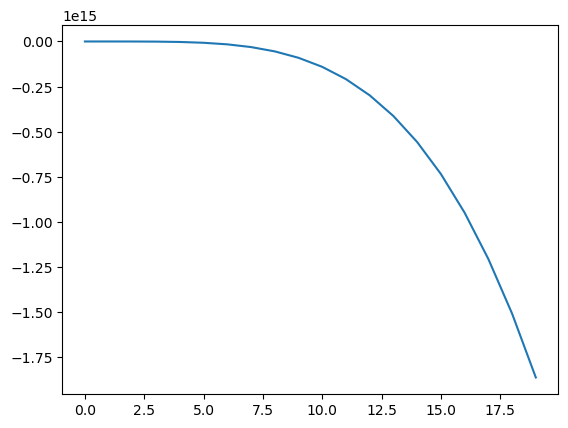

In [133]:
avg_loss = update_average_loss([], average_loss)

# Evaluation and Training for more epochs

# For 20 epochs

## Load model from checkpoint 20

In [130]:
current_checkpoint = 20
model = load_unet_model(3, 3, current_checkpoint)

## Set test for 20 epochs

In [139]:
set_test(current_checkpoint)

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


100%|██████████| 138/138 [02:10<00:00,  1.05it/s]

Test finished.


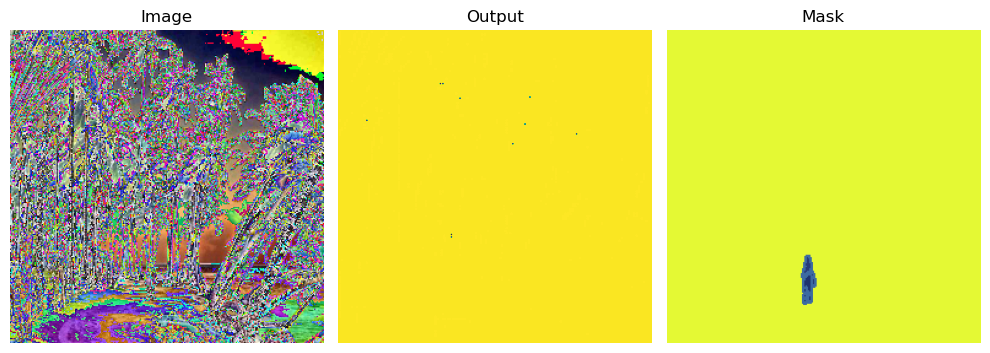

In [150]:
test_predicted_image(16, current_checkpoint)

In [176]:
iou_scores = calculate_average_iou(current_checkpoint, test_loader)

138


100%|██████████| 138/138 [00:14<00:00,  9.52it/s]


Average IoU: 0.48578548431396484


In [178]:
iou_scores

{1: 0.4797077178955078,
 2: 0.49719810485839844,
 3: 0.5054779052734375,
 4: 0.4836864471435547,
 5: 0.4587211608886719,
 6: 0.5170059204101562,
 7: 0.45332908630371094,
 8: 0.5023097991943359,
 9: 0.4831275939941406,
 10: 0.4908485412597656,
 11: 0.5056419372558594,
 12: 0.5027503967285156,
 13: 0.5142917633056641,
 14: 0.48728370666503906,
 15: 0.5376453399658203,
 16: 0.5085086822509766,
 17: 0.47232818603515625,
 18: 0.5107364654541016,
 19: 0.48715972900390625,
 20: 0.5032901763916016,
 21: 0.4765033721923828,
 22: 0.48642539978027344,
 23: 0.4849262237548828,
 24: 0.4778900146484375,
 25: 0.5015850067138672,
 26: 0.5211429595947266,
 27: 0.5365085601806641,
 28: 0.48128318786621094,
 29: 0.4925251007080078,
 30: 0.45321083068847656,
 31: 0.4770488739013672,
 32: 0.48882102966308594,
 33: 0.5108470916748047,
 34: 0.4668598175048828,
 35: 0.5121784210205078,
 36: 0.49103736877441406,
 37: 0.46086883544921875,
 38: 0.5003242492675781,
 39: 0.5226840972900391,
 40: 0.4341983795166015

In [183]:
print(f'Max IoU score: {iou_scores[max(iou_scores, key=iou_scores.get)]}')
print(f'Avg IoU score: {sum(iou_scores.values()) / len(iou_scores)}')
print(f'Min IoU score: {iou_scores[min(iou_scores, key=iou_scores.get)]}')

Max IoU score: 0.5376453399658203
Avg IoU score: 0.48578548431396484
Min IoU score: 0.4155406951904297


In [286]:
iou_20 = {1: 0.4797077178955078,
 2: 0.49719810485839844,
 3: 0.5054779052734375,
 4: 0.4836864471435547,
 5: 0.4587211608886719,
 6: 0.5170059204101562,
 7: 0.45332908630371094,
 8: 0.5023097991943359,
 9: 0.4831275939941406,
 10: 0.4908485412597656,
 11: 0.5056419372558594,
 12: 0.5027503967285156,
 13: 0.5142917633056641,
 14: 0.48728370666503906,
 15: 0.5376453399658203,
 16: 0.5085086822509766,
 17: 0.47232818603515625,
 18: 0.5107364654541016,
 19: 0.48715972900390625,
 20: 0.5032901763916016,
 21: 0.4765033721923828,
 22: 0.48642539978027344,
 23: 0.4849262237548828,
 24: 0.4778900146484375,
 25: 0.5015850067138672,
 26: 0.5211429595947266,
 27: 0.5365085601806641,
 28: 0.48128318786621094,
 29: 0.4925251007080078,
 30: 0.45321083068847656,
 31: 0.4770488739013672,
 32: 0.48882102966308594,
 33: 0.5108470916748047,
 34: 0.4668598175048828,
 35: 0.5121784210205078,
 36: 0.49103736877441406,
 37: 0.46086883544921875,
 38: 0.5003242492675781,
 39: 0.5226840972900391,
 40: 0.43419837951660156,
 41: 0.46941375732421875,
 42: 0.5030574798583984,
 43: 0.461761474609375,
 44: 0.42952919006347656,
 45: 0.5254783630371094,
 46: 0.49345970153808594,
 47: 0.46932220458984375,
 48: 0.467071533203125,
 49: 0.470855712890625,
 50: 0.4504280090332031,
 51: 0.49939727783203125,
 52: 0.4945259094238281,
 53: 0.4984416961669922,
 54: 0.48110008239746094,
 55: 0.4626426696777344,
 56: 0.4664497375488281,
 57: 0.4702434539794922,
 58: 0.502227783203125,
 59: 0.4833030700683594,
 60: 0.5153923034667969,
 61: 0.4472484588623047,
 62: 0.510711669921875,
 63: 0.4729633331298828,
 64: 0.5034217834472656,
 65: 0.484039306640625,
 66: 0.5336399078369141,
 67: 0.47216224670410156,
 68: 0.4899578094482422,
 69: 0.4744148254394531,
 70: 0.5169944763183594,
 71: 0.5161838531494141,
 72: 0.49959754943847656,
 73: 0.49039459228515625,
 74: 0.4709129333496094,
 75: 0.46036720275878906,
 76: 0.4723625183105469,
 77: 0.4691295623779297,
 78: 0.5065994262695312,
 79: 0.5236225128173828,
 80: 0.5024280548095703,
 81: 0.4970741271972656,
 82: 0.5109024047851562,
 83: 0.4438209533691406,
 84: 0.447998046875,
 85: 0.4522743225097656,
 86: 0.4795970916748047,
 87: 0.4568958282470703,
 88: 0.4693107604980469,
 89: 0.5003166198730469,
 90: 0.4722728729248047,
 91: 0.5003223419189453,
 92: 0.49050331115722656,
 93: 0.4409294128417969,
 94: 0.5047588348388672,
 95: 0.49088478088378906,
 96: 0.4893455505371094,
 97: 0.49039649963378906,
 98: 0.47977447509765625,
 99: 0.44307899475097656,
 100: 0.4570293426513672,
 101: 0.455078125,
 102: 0.4876518249511719,
 103: 0.49330902099609375,
 104: 0.5086383819580078,
 105: 0.5219573974609375,
 106: 0.4962921142578125,
 107: 0.4651641845703125,
 108: 0.5200901031494141,
 109: 0.5255012512207031,
 110: 0.46331024169921875,
 111: 0.47920799255371094,
 112: 0.487701416015625,
 113: 0.4798393249511719,
 114: 0.5105514526367188,
 115: 0.49677467346191406,
 116: 0.48928260803222656,
 117: 0.4619941711425781,
 118: 0.4581413269042969,
 119: 0.5068607330322266,
 120: 0.509735107421875,
 121: 0.5170879364013672,
 122: 0.4690532684326172,
 123: 0.4920177459716797,
 124: 0.4749031066894531,
 125: 0.4155406951904297,
 126: 0.4807319641113281,
 127: 0.4531726837158203,
 128: 0.48723602294921875,
 129: 0.4774131774902344,
 130: 0.4651527404785156,
 131: 0.5096721649169922,
 132: 0.47255516052246094,
 133: 0.5029182434082031,
 134: 0.4740161895751953,
 135: 0.46146392822265625,
 136: 0.5080909729003906,
 137: 0.4591064453125,
 138: 0.47452545166015625}

# TODO: (by TG) make a json dump file for this...

#### IoU for 20 epochs

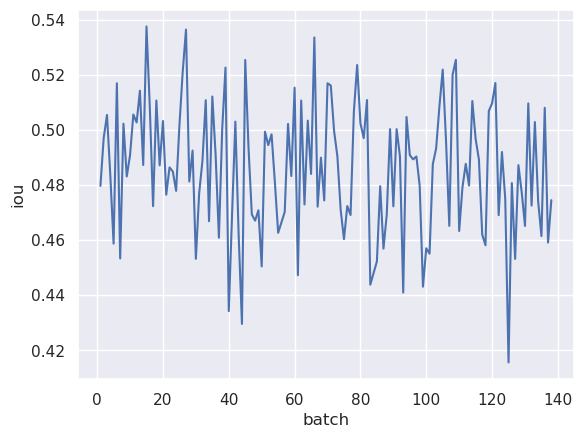

In [311]:
plt.plot(iou_20.keys(), iou_20.values(), label='iou_20')
plt.xlabel('batch')
plt.ylabel('iou')
plt.show()

# For 100 epochs

## Set training for 100 epochs (20 + 80)

In [154]:
training_loop(model, 20, 80, train_loader, criterion, optimizer)

Device in use: cuda
Using 1 GPUs.


Epoch 10/80: 100%|██████████| 183/183 [00:26<00:00,  6.87it/s]


Model saved: modelo_30.pth


Epoch 20/80: 100%|██████████| 183/183 [00:29<00:00,  6.17it/s]


Model saved: modelo_40.pth


Epoch 30/80: 100%|██████████| 183/183 [00:35<00:00,  5.13it/s]


Model saved: modelo_50.pth


Epoch 40/80: 100%|██████████| 183/183 [00:32<00:00,  5.71it/s]


Model saved: modelo_60.pth


Epoch 50/80: 100%|██████████| 183/183 [00:36<00:00,  5.03it/s]


Model saved: modelo_70.pth


Epoch 60/80: 100%|██████████| 183/183 [00:31<00:00,  5.73it/s]


Model saved: modelo_80.pth


Epoch 70/80: 100%|██████████| 183/183 [00:31<00:00,  5.85it/s]


Model saved: modelo_90.pth


Epoch 80/80: 100%|██████████| 183/183 [00:43<00:00,  4.22it/s]


Model saved: modelo_100.pth
Finished Training


In [171]:
current_checkpoint = 100
model = load_unet_model(3, 3, current_checkpoint)
test_loader = set_test(current_checkpoint)

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


100%|██████████| 138/138 [01:52<00:00,  1.22it/s]

Test finished.


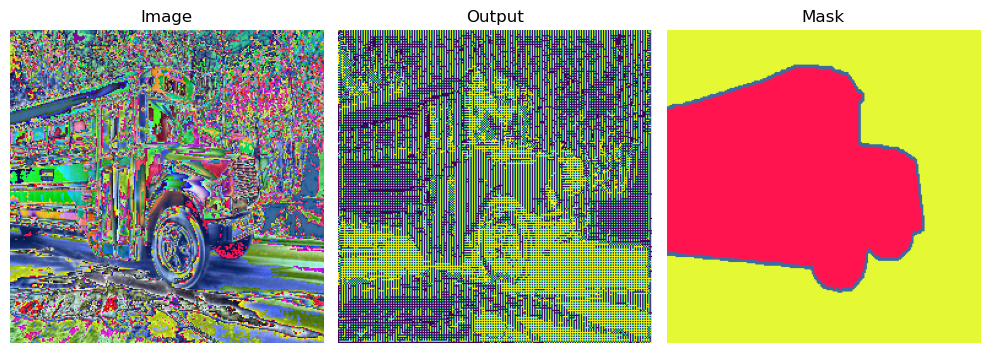

In [189]:
test_predicted_image(14, current_checkpoint)

In [ ]:
current_checkpoint = 100
model = load_unet_model(3, 3, current_checkpoint)
test_loader = set_test(model, current_checkpoint)
iou_scores, accuracies = calculate_average_metrics(current_checkpoint, test_loader)
f1_scores = calculate_f1_score(current_checkpoint)


# Training for 400 epochs (100+300)

In [191]:
training_loop(model, 100, 300, train_loader, criterion, optimizer)

Device in use: cuda
Using 1 GPUs.


Epoch 10/300: 100%|██████████| 183/183 [00:27<00:00,  6.69it/s]


Model saved: modelo_110.pth


Epoch 20/300: 100%|██████████| 183/183 [00:30<00:00,  6.07it/s]


Model saved: modelo_120.pth


Epoch 30/300: 100%|██████████| 183/183 [00:30<00:00,  5.92it/s]


Model saved: modelo_130.pth


Epoch 40/300: 100%|██████████| 183/183 [00:34<00:00,  5.27it/s]


Model saved: modelo_140.pth


Epoch 50/300: 100%|██████████| 183/183 [00:37<00:00,  4.88it/s]


Model saved: modelo_150.pth


Epoch 60/300: 100%|██████████| 183/183 [00:37<00:00,  4.89it/s]


Model saved: modelo_160.pth


Epoch 70/300: 100%|██████████| 183/183 [00:37<00:00,  4.89it/s]


Model saved: modelo_170.pth


Epoch 80/300: 100%|██████████| 183/183 [00:38<00:00,  4.71it/s]


Model saved: modelo_180.pth


Epoch 90/300: 100%|██████████| 183/183 [00:41<00:00,  4.45it/s]


Model saved: modelo_190.pth


Epoch 100/300: 100%|██████████| 183/183 [00:38<00:00,  4.76it/s]


Model saved: modelo_200.pth


Epoch 110/300: 100%|██████████| 183/183 [00:42<00:00,  4.27it/s]


Model saved: modelo_210.pth


Epoch 120/300: 100%|██████████| 183/183 [00:42<00:00,  4.28it/s]


Model saved: modelo_220.pth


Epoch 130/300: 100%|██████████| 183/183 [00:40<00:00,  4.48it/s]


Model saved: modelo_230.pth


Epoch 140/300: 100%|██████████| 183/183 [00:41<00:00,  4.45it/s]


Model saved: modelo_240.pth


Epoch 150/300: 100%|██████████| 183/183 [00:40<00:00,  4.49it/s]


Model saved: modelo_250.pth


Epoch 160/300: 100%|██████████| 183/183 [00:39<00:00,  4.69it/s]


Model saved: modelo_260.pth


Epoch 170/300: 100%|██████████| 183/183 [00:40<00:00,  4.48it/s]


Model saved: modelo_270.pth


Epoch 180/300: 100%|██████████| 183/183 [00:45<00:00,  4.04it/s]


Model saved: modelo_280.pth


Epoch 190/300: 100%|██████████| 183/183 [00:40<00:00,  4.54it/s]


Model saved: modelo_290.pth


Epoch 200/300: 100%|██████████| 183/183 [00:37<00:00,  4.83it/s]


Model saved: modelo_300.pth


Epoch 210/300: 100%|██████████| 183/183 [00:40<00:00,  4.53it/s]


Model saved: modelo_310.pth


Epoch 220/300: 100%|██████████| 183/183 [00:37<00:00,  4.87it/s]


Model saved: modelo_320.pth


Epoch 230/300: 100%|██████████| 183/183 [00:38<00:00,  4.70it/s]


Model saved: modelo_330.pth


Epoch 240/300: 100%|██████████| 183/183 [00:40<00:00,  4.57it/s]


Model saved: modelo_340.pth


Epoch 250/300: 100%|██████████| 183/183 [00:40<00:00,  4.52it/s]


Model saved: modelo_350.pth


Epoch 260/300: 100%|██████████| 183/183 [00:40<00:00,  4.50it/s]


Model saved: modelo_360.pth


Epoch 270/300: 100%|██████████| 183/183 [00:41<00:00,  4.45it/s]


Model saved: modelo_370.pth


Epoch 280/300: 100%|██████████| 183/183 [00:41<00:00,  4.43it/s]


Model saved: modelo_380.pth


Epoch 290/300: 100%|██████████| 183/183 [00:40<00:00,  4.48it/s]


Model saved: modelo_390.pth


Epoch 300/300: 100%|██████████| 183/183 [00:40<00:00,  4.47it/s]

Model saved: modelo_400.pth
Finished Training


## Set test for 150 epochs

In [294]:
current_checkpoint = 150
model = load_unet_model(3, 3, current_checkpoint)
test_loader = set_test(model, current_checkpoint)

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation
Using 1 GPUs.
Using 8 CPU cores.


100%|██████████| 138/138 [01:00<00:00,  2.30it/s]

Test finished.


Accuracy and IoU

In [301]:
iou_scores, accuracies = calculate_average_metrics(current_checkpoint, test_loader)

100%|██████████| 138/138 [00:27<00:00,  5.04it/s]


Average IoU: 0.8618446156598519
Average Accuracy: tensor(0.8618)


In [296]:
print(f'Max IoU score: {iou_scores[max(iou_scores, key=iou_scores.get)]}')
print(f'Avg IoU score: {sum(iou_scores.values()) / len(iou_scores)}')
print(f'Min IoU score: {iou_scores[min(iou_scores, key=iou_scores.get)]}')

Max IoU score: 0.9996376037597656
Avg IoU score: 0.9987327603326328
Min IoU score: 0.9963512420654297


F1 score

In [302]:
f1_scores = calculate_f1_score(current_checkpoint)

100%|██████████| 138/138 [00:02<00:00, 63.20it/s]


Average F1 Score: 1.0


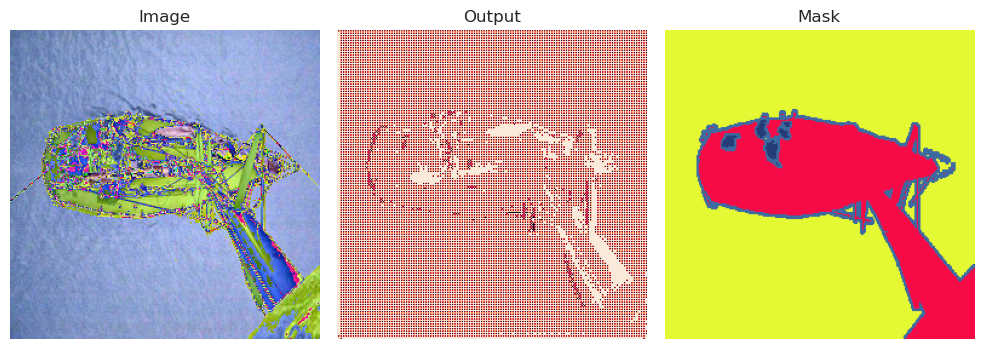

In [303]:
current_checkpoint = 150
test_predicted_image(12, current_checkpoint)

## For 300 epochs

In [328]:
current_checkpoint = 300
model = load_unet_model(3, 3, current_checkpoint)
test_loader = set_test(model, current_checkpoint)
iou_scores, accuracies = calculate_average_metrics(current_checkpoint, test_loader)
f1_scores = calculate_f1_score(current_checkpoint)

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation
Using 1 GPUs.
Using 8 CPU cores.


100%|██████████| 138/138 [01:49<00:00,  1.25it/s]


Test finished.
Calculating IoU and accuracy for checkpoint 300...


100%|██████████| 138/138 [00:32<00:00,  4.31it/s]



Average IoU: 0.8205899362978728
Average Accuracy: 0.6763805150985718

Calculating F1 score for checkpoint 300...


100%|██████████| 138/138 [00:02<00:00, 54.14it/s]


Average F1 Score: 0.9999999953928763



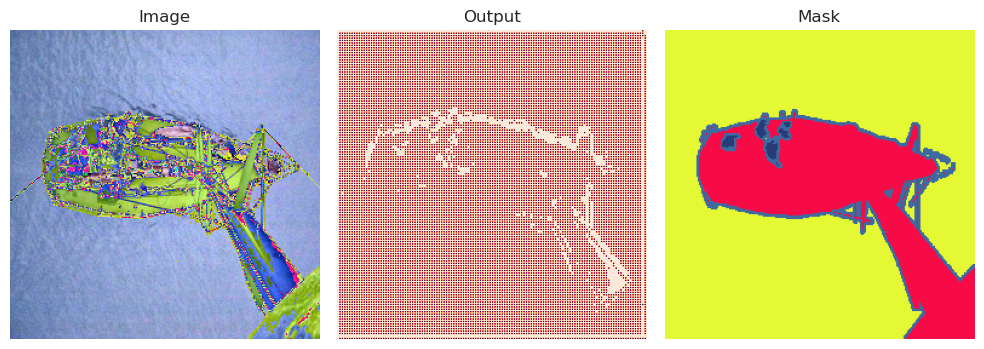

In [329]:
test_predicted_image(12, 300)

## For 400 epochs

In [361]:
current_checkpoint = 400
model = load_unet_model(3, 3, current_checkpoint)
test_loader = set_test(model, current_checkpoint)
iou_scores, accuracies = calculate_average_metrics(current_checkpoint, test_loader)
f1_scores = calculate_f1_score(current_checkpoint)

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation
Using 1 GPUs.
Using 8 CPU cores.


100%|██████████| 138/138 [00:59<00:00,  2.33it/s]


Test finished.
Calculating IoU and accuracy for checkpoint 400...


100%|██████████| 138/138 [00:28<00:00,  4.88it/s]



Average IoU: 0.9999493999757628
Average Accuracy: 0.8585827350616455

Calculating F1 score for checkpoint 400...


100%|██████████| 138/138 [00:02<00:00, 60.64it/s]


Average F1 Score: 0.9999999884821908



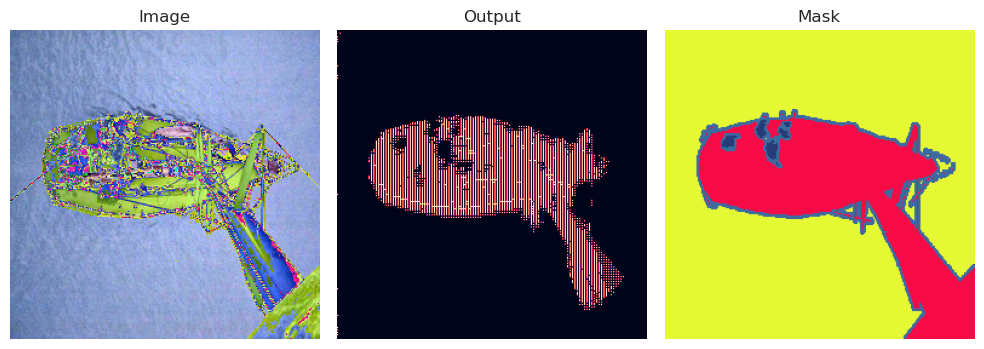

In [318]:
test_predicted_image(12, 400)

# REST

- `TODO`: (**by TG**) Experimental code that will be `reused/optimized/cleaned` afterwards

In [163]:
calculate_average_iou(current_checkpoint)

  0%|          | 0/182 [00:00<?, ?it/s]


RuntimeError: The size of tensor a (8) must match the size of tensor b (3) at non-singleton dimension 1

In [127]:
masks.shape

torch.Size([8, 3, 256, 256])

In [112]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)
        )
        # Output layer
        self.out = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        out = self.out(x2)
        return out.squeeze(1)  # Return segmentation map tensor


In [118]:
import multiprocessing
from torch.utils.data import DataLoader


def training_loop(model, current_checkpoint: int, num_epochs: int,
                  train_loader: DataLoader, criterion, optimizer: optim.Optimizer):
    """ Training loop. """
    

    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Set the number of CPU cores to use
    num_cpu = multiprocessing.cpu_count()

    print(f"Device in use: {device}")

    # Move the model to the device
    model = model.to(device)

    # Wrap the model with DataParallel if multiple GPUs or CPUs are available
    if torch.cuda.device_count() >= 1:
        print(f"Using {torch.cuda.device_count()} GPUs.")
        model = nn.DataParallel(model)
    elif num_cpu > 1:
        print(f"Using {num_cpu} CPU cores.")
        model = nn.DataParallel(model)
    else:
        print("Using single CPU.")
        
    # Set the model to training mode
    model.train()

    # Define the average loss list
    average_loss = []

    # Training loop
    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        for images, masks in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1, position=0):
            # Move data to the device
            images = images.to(device)
            masks = masks.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            #outputs = model(images)['out']
            outputs = model(images)

            # Calculate the loss
            #loss = criterion(outputs, masks.squeeze(1).long())
            loss = criterion(outputs, masks.unsqueeze(1).float().squeeze(2))


            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Print the average loss for the given epoch
        average_loss.append(running_loss / len(train_loader))
        # saving every 10 epochs
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"n_modelo_{current_checkpoint+epoch}.pth")
            print(f"Model saved: modelo_{current_checkpoint+epoch}.pth")
        
    print("Finished Training")

In [123]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
import torch.nn as nn
import torch.optim as optim

# Paths
dataset_dir = "../data/pascal_voc_dataset/VOCdevkit/VOC2012/JPEGImages"
train_dir = "../data/pascal_voc_dataset/train"
val_dir = "../data/pascal_voc_dataset/validation"
test_dir = "../data/pascal_voc_dataset/test"
mask_dir = "../data/pascal_voc_dataset/VOCdevkit/VOC2012/mask"

# Transforms to input images
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(),  # Convert to single-channel grayscale
    transforms.ToTensor(),
])

# Download and load the PASCAL VOC dataset
train_set = VOCSegmentation(root=train_dir, year='2012', image_set='train', download=True, transform=transform, target_transform=mask_transform)
val_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
test_set = val_set

# Split dataset
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)


model = UNet()


# Loss function
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


Using downloaded and verified file: ../data/pascal_voc_dataset/train/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/train/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/train
Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


In [121]:
current_checkpoint = 0

In [122]:
training_loop(model, current_checkpoint, 20, train_loader, criterion, optimizer)

Device in use: cuda
Using 1 GPUs.


Epoch 1/20:   0%|          | 0/183 [00:00<?, ?it/s]


ValueError: Target size (torch.Size([8, 1, 256, 256])) must be the same as input size (torch.Size([8, 256, 256]))

In [6]:
import multiprocessing
from torch.utils.data import DataLoader

#model = deeplabv3_resnet50(weight=True)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the number of CPU cores to use
num_cpu = multiprocessing.cpu_count()

print(f"Device in use: {device}")

# Move the model to the device
model = model.to(device)

# Wrap the model with DataParallel if multiple GPUs or CPUs are available
if torch.cuda.device_count() >= 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(model)
elif num_cpu > 1:
    print(f"Using {num_cpu} CPU cores.")
    model = nn.DataParallel(model)
else:
    print("Using single GPU or CPU.")
    
# Define the loss function
#criterion = nn.CrossEntropyLoss()

# Define the optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the model to training mode
model.train()

# Define the data loader
#train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Adjust batch_size and other parameters

#train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

# Define the number of epochs
num_epochs = 20

# Define the average loss list
average_loss = []

# Training loop
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    for images, masks in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1, position=0):
        # Move data to the device
        images = images.to(device)
        masks = masks.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        #outputs = model(images)['out']
        outputs = model(images)

        # Calculate the loss
        #loss = criterion(outputs, masks.squeeze(1).long())
        loss = criterion(outputs, masks.unsqueeze(1).float().squeeze(2))


        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for the given epoch
    average_loss.append(running_loss / len(train_loader))
    # saving every 10 epochs
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"n_modelo_{current_checkpoint+epoch}.pth")
        print(f"Model saved: modelo_{current_checkpoint+epoch}.pth")
    #print(f"Epoch [{epoch}/{num_epochs}], Loss: {average_loss[-1]}")

# Save the trained model

Device in use: cuda
Using 1 GPUs.


Epoch 10/20: 100%|██████████| 183/183 [00:30<00:00,  6.01it/s]


Model saved: modelo_10.pth


Epoch 20/20: 100%|██████████| 183/183 [00:32<00:00,  5.59it/s]

Model saved: modelo_20.pth


In [42]:
average_loss

[0.37319588164488476,
 0.3719679596808439,
 0.3691500632163605,
 0.36747703119053865,
 0.3666572610700065,
 0.3647408145047276,
 0.36373205466674324,
 0.3638461534279943,
 0.36240784921607033,
 0.3604973939761438,
 0.3604383679524146,
 0.35917985081021253,
 0.3602402689841276,
 0.35747125557537285,
 0.3576149700280747,
 0.35627455528968016,
 0.3577086350631193,
 0.3567337242306256,
 0.3556958868529627,
 0.35377030571301776]

In [58]:
avg_loss = [0.37319588164488476,
 0.3719679596808439,
 0.3691500632163605,
 0.36747703119053865,
 0.3666572610700065,
 0.3647408145047276,
 0.36373205466674324,
 0.3638461534279943,
 0.36240784921607033,
 0.3604973939761438,
 0.3604383679524146,
 0.35917985081021253,
 0.3602402689841276,
 0.35747125557537285,
 0.3576149700280747,
 0.35627455528968016,
 0.3577086350631193,
 0.3567337242306256,
 0.3556958868529627,
 0.35377030571301776]

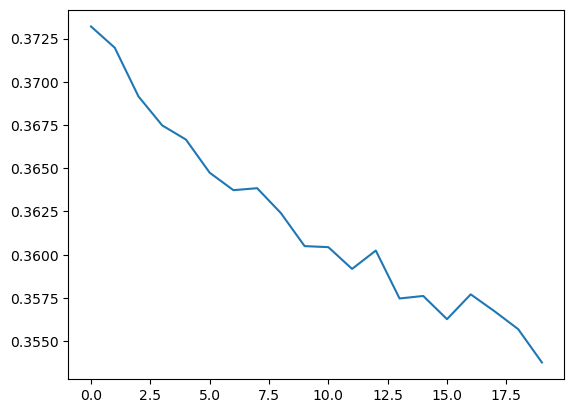

In [44]:
# plot average loss over the epochs
plt.plot(average_loss)
plt.show()

## Setting test loader

In [8]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import Subset
from tqdm import tqdm

val_dir = "../data/pascal_voc_dataset/validation"
test_dir = "../data/pascal_voc_dataset/test"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(),  # Convert to single-channel grayscale
    transforms.ToTensor(),
])

test_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
test_set = Subset(test_set, range(1100))

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


In [9]:
test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

In [12]:
for i, (images, masks) in enumerate(tqdm(test_loader), start=1):
    with torch.no_grad():
        outputs = model(images)
    
    # Save each prediction as separate files using torch.save()
    torch.save(images, f'../rsc/test/image_{i}.pth')
    torch.save(outputs, f'../rsc/ntest20/output_{i}.pth')
    torch.save(masks, f'../rsc/test/mask_{i}.pth')

100%|██████████| 138/138 [00:14<00:00,  9.32it/s]


In [37]:
index = 38
image = torch.load(f'../rsc/test/image_{index}.pth')
output = torch.load(f'../rsc/ntest20/output_{index}.pth')
mask = torch.load(f'../rsc/test/mask_{index}.pth')

image.shape, output.shape, mask.shape

(torch.Size([8, 3, 256, 256]),
 torch.Size([8, 1, 256, 256]),
 torch.Size([8, 1, 256, 256]))

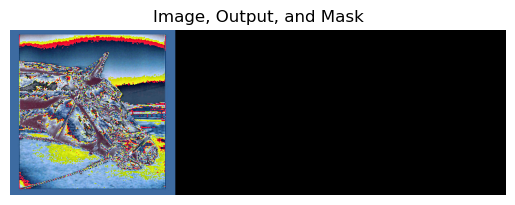

In [50]:
import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

# Select a specific image from the batch (e.g., the first image)
image_single = image[0]
output_single = output[0].argmax(dim=0).unsqueeze(0).to(torch.float32)  # Add batch dimension
mask_single = mask[0]

# Convert the single image and mask tensors to PIL images
image_pil = transforms.ToPILImage()(image_single.cpu())

# Convert the output and mask tensors to PIL images and convert to RGB format
output_pil = transforms.ToPILImage()(output_single.cpu().squeeze().to(torch.uint8)).convert('RGB')
mask_pil = transforms.ToPILImage()(mask_single.cpu().squeeze().to(torch.uint8)).convert('RGB')

# Convert the PIL images to NumPy arrays
image_np = np.array(image_pil)
output_np = np.array(output_pil)
mask_np = np.array(mask_pil)

# Create a grid of images
grid = np.concatenate([image_np, output_np, mask_np], axis=1)

# Plot the grid
plt.imshow(grid)
plt.title('Image, Output, and Mask')
plt.axis('off')
plt.show()


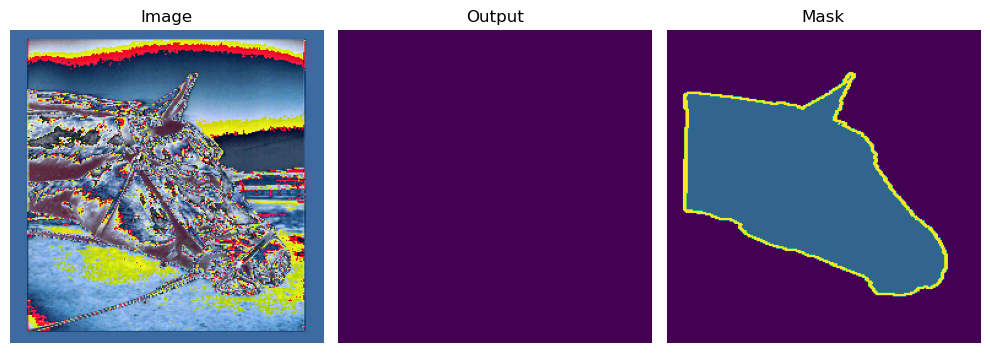

In [55]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

index = 38
image = torch.load(f'../rsc/test/image_{index}.pth')
output = torch.load(f'../rsc/ntest20/output_{index}.pth')
mask = torch.load(f'../rsc/test/mask_{index}.pth')

image.shape, output.shape, mask.shape

# Select a specific image from the batch (e.g., the first image)
image_single = image[0]
output_single = output[0].argmax(dim=0, keepdim=True)
mask_single = mask[0]

# Scale the output and mask tensors to the range [0, 255]
output_single_scaled = (output_single * 255).to(torch.uint8)
mask_single_scaled = (mask_single * 255).to(torch.uint8)

# Convert the single image and scaled tensors to PIL images
image_pil = transforms.ToPILImage()(image_single.cpu())
output_pil = transforms.ToPILImage()(output_single_scaled.cpu().squeeze())
mask_pil = transforms.ToPILImage()(mask_single_scaled.cpu().squeeze())

# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Plot the images in the subplots
axes[0].imshow(image_pil)
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(output_pil)
axes[1].set_title('Output')
axes[1].axis('off')

axes[2].imshow(mask_pil)
axes[2].set_title('Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()


## Training for over 20 epochs

In [56]:
current_checkpoint = 20

In [57]:
import multiprocessing
from torch.utils.data import DataLoader

#model = deeplabv3_resnet50(weight=True)

current_checkpoint = 20

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the number of CPU cores to use
num_cpu = multiprocessing.cpu_count()

print(f"Device in use: {device}")

# Move the model to the device
model = model.to(device)

# Wrap the model with DataParallel if multiple GPUs or CPUs are available
if torch.cuda.device_count() >= 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(model)
elif num_cpu > 1:
    print(f"Using {num_cpu} CPU cores.")
    model = nn.DataParallel(model)
else:
    print("Using single GPU or CPU.")
    
# Define the loss function
#criterion = nn.CrossEntropyLoss()

# Define the optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the model to training mode
model.train()

# Define the data loader
#train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Adjust batch_size and other parameters

#train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

# Define the number of epochs
num_epochs = 20

# Define the average loss list
average_loss = []

# Training loop
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    for images, masks in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1, position=0):
        # Move data to the device
        images = images.to(device)
        masks = masks.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        #outputs = model(images)['out']
        outputs = model(images)

        # Calculate the loss
        #loss = criterion(outputs, masks.squeeze(1).long())
        loss = criterion(outputs, masks.unsqueeze(1).float().squeeze(2))


        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for the given epoch
    average_loss.append(running_loss / len(train_loader))
    # saving every 10 epochs
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"n_modelo_{current_checkpoint+epoch}.pth")
        print(f"Model saved: modelo_{current_checkpoint+epoch}.pth")

Device in use: cuda
Using 1 GPUs.


Epoch 10/20: 100%|██████████| 183/183 [00:29<00:00,  6.22it/s]


Model saved: modelo_30.pth


Epoch 20/20: 100%|██████████| 183/183 [00:32<00:00,  5.67it/s]

Model saved: modelo_40.pth


In [59]:
average_loss

[0.35641822284036645,
 0.3540027541378157,
 0.3545653425116357,
 0.35225114592763246,
 0.35283141505848514,
 0.35329381844710783,
 0.35136777960537563,
 0.35178856396935676,
 0.35295154032160025,
 0.35125196411635706,
 0.35188570203351194,
 0.35181714040659817,
 0.3514474149121613,
 0.3492979939843788,
 0.349271175721304,
 0.3507007383257965,
 0.3502523898264098,
 0.3508897014980108,
 0.35020682630968875,
 0.348823435726713]

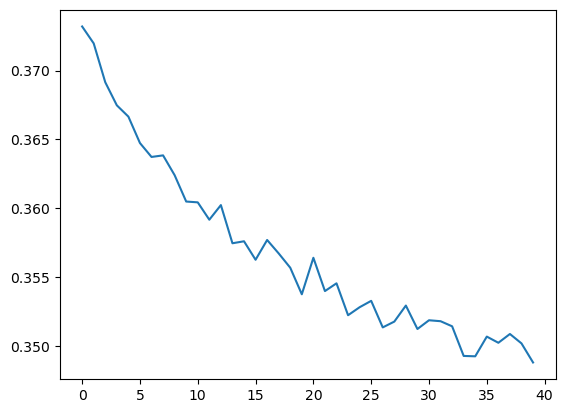

In [64]:
avg_loss.extend(average_loss)
plt.plot(avg_loss)

In [67]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import Subset
from tqdm import tqdm

val_dir = "../data/pascal_voc_dataset/validation"
test_dir = "../data/pascal_voc_dataset/test"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(),  # Convert to single-channel grayscale
    transforms.ToTensor(),
])

test_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
test_set = Subset(test_set, range(1100))

test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

for i, (images, masks) in enumerate(tqdm(test_loader), start=1):
    with torch.no_grad():
        outputs = model(images)
    
    # Save each prediction as separate files using torch.save()
    torch.save(images, f'../rsc/test/image_{i}.pth')
    torch.save(outputs, f'../rsc/ntest40/output_{i}.pth')
    torch.save(masks, f'../rsc/test/mask_{i}.pth')

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


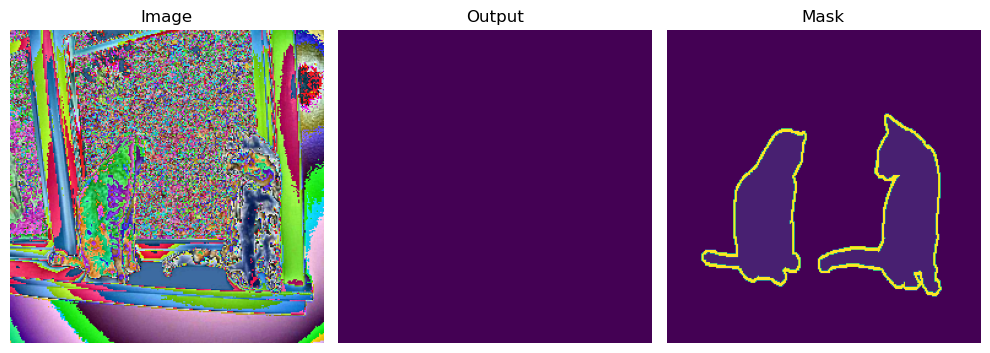

In [69]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

index = 38
image = torch.load(f'../rsc/test/image_{index}.pth')
output = torch.load(f'../rsc/ntest20/output_{index}.pth')
mask = torch.load(f'../rsc/test/mask_{index}.pth')

image.shape, output.shape, mask.shape

# Select a specific image from the batch (e.g., the first image)
image_single = image[0]
output_single = output[0].argmax(dim=0, keepdim=True)
mask_single = mask[0]

# Scale the output and mask tensors to the range [0, 255]
output_single_scaled = (output_single * 255).to(torch.uint8)
mask_single_scaled = (mask_single * 255).to(torch.uint8)

# Convert the single image and scaled tensors to PIL images
image_pil = transforms.ToPILImage()(image_single.cpu())
output_pil = transforms.ToPILImage()(output_single_scaled.cpu().squeeze())
mask_pil = transforms.ToPILImage()(mask_single_scaled.cpu().squeeze())

# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Plot the images in the subplots
axes[0].imshow(image_pil)
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(output_pil)
axes[1].set_title('Output')
axes[1].axis('off')

axes[2].imshow(mask_pil)
axes[2].set_title('Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()


## Training for over 40 epochs

In [70]:
import multiprocessing
from torch.utils.data import DataLoader

#model = deeplabv3_resnet50(weight=True)

current_checkpoint = 40

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the number of CPU cores to use
num_cpu = multiprocessing.cpu_count()

print(f"Device in use: {device}")

# Move the model to the device
model = model.to(device)

# Wrap the model with DataParallel if multiple GPUs or CPUs are available
if torch.cuda.device_count() >= 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(model)
elif num_cpu > 1:
    print(f"Using {num_cpu} CPU cores.")
    model = nn.DataParallel(model)
else:
    print("Using single GPU or CPU.")
    
# Define the loss function
#criterion = nn.CrossEntropyLoss()

# Define the optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the model to training mode
model.train()

# Define the data loader
#train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Adjust batch_size and other parameters

#train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

# Define the number of epochs
num_epochs = 60

# Define the average loss list
average_loss = []

# Training loop
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    for images, masks in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1, position=0):
        # Move data to the device
        images = images.to(device)
        masks = masks.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        #outputs = model(images)['out']
        outputs = model(images)

        # Calculate the loss
        #loss = criterion(outputs, masks.squeeze(1).long())
        loss = criterion(outputs, masks.unsqueeze(1).float().squeeze(2))


        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for the given epoch
    average_loss.append(running_loss / len(train_loader))
    # saving every 10 epochs
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"n_modelo_{current_checkpoint+epoch}.pth")
        print(f"Model saved: modelo_{current_checkpoint+epoch}.pth")

Device in use: cuda
Using 1 GPUs.


Epoch 10/60: 100%|██████████| 183/183 [00:33<00:00,  5.44it/s]


Model saved: modelo_50.pth


Epoch 20/60: 100%|██████████| 183/183 [00:36<00:00,  4.97it/s]


Model saved: modelo_60.pth


Epoch 30/60: 100%|██████████| 183/183 [00:38<00:00,  4.73it/s]


Model saved: modelo_70.pth


Epoch 40/60: 100%|██████████| 183/183 [00:37<00:00,  4.84it/s]


Model saved: modelo_80.pth


Epoch 50/60: 100%|██████████| 183/183 [00:36<00:00,  4.96it/s]


Model saved: modelo_90.pth


Epoch 60/60: 100%|██████████| 183/183 [00:42<00:00,  4.34it/s]

Model saved: modelo_100.pth


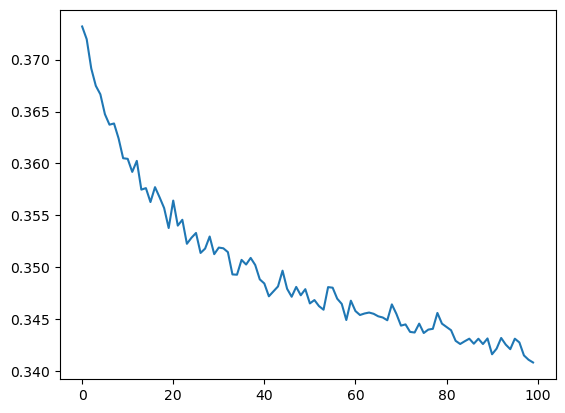

In [71]:
avg_loss.extend(average_loss)
plt.plot(avg_loss)

In [72]:
current_checkpoint = 100

In [73]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import Subset
from tqdm import tqdm

val_dir = "../data/pascal_voc_dataset/validation"
test_dir = "../data/pascal_voc_dataset/test"

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Grayscale(),  # Convert to single-channel grayscale
    transforms.ToTensor(),
])

test_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
test_set = Subset(test_set, range(1100))

test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

for i, (images, masks) in enumerate(tqdm(test_loader), start=1):
    with torch.no_grad():
        outputs = model(images)
    
    # Save each prediction as separate files using torch.save()
    torch.save(images, f'../rsc/test/image_{i}.pth')
    torch.save(outputs, f'../rsc/ntest{current_checkpoint}/output_{i}.pth')
    torch.save(masks, f'../rsc/test/mask_{i}.pth')

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


100%|██████████| 138/138 [00:22<00:00,  6.26it/s]


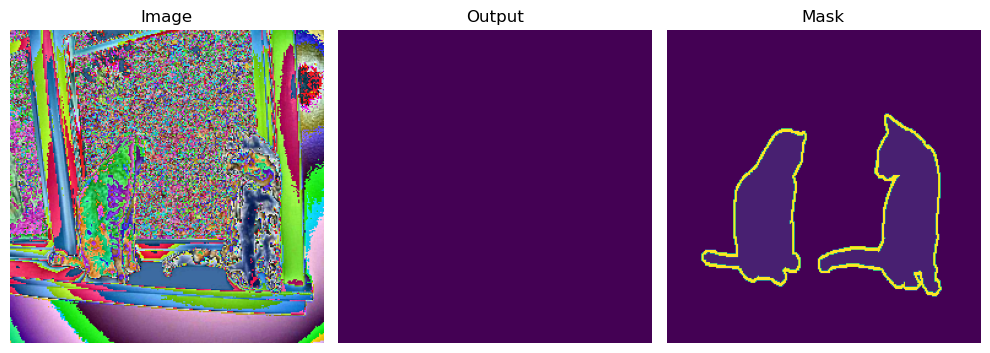

In [75]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

index = 38
image = torch.load(f'../rsc/test/image_{index}.pth')
output = torch.load(f'../rsc/ntest20/output_{index}.pth')
mask = torch.load(f'../rsc/test/mask_{index}.pth')

image.shape, output.shape, mask.shape

# Select a specific image from the batch (e.g., the first image)
image_single = image[0]
output_single = output[0].argmax(dim=0, keepdim=True)
mask_single = mask[0]

# Scale the output and mask tensors to the range [0, 255]
output_single_scaled = (output_single * 255).to(torch.uint8)
mask_single_scaled = (mask_single * 255).to(torch.uint8)

# Convert the single image and scaled tensors to PIL images
image_pil = transforms.ToPILImage()(image_single.cpu())
output_pil = transforms.ToPILImage()(output_single_scaled.cpu().squeeze())
mask_pil = transforms.ToPILImage()(mask_single_scaled.cpu().squeeze())

# Create a grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

# Plot the images in the subplots
axes[0].imshow(image_pil)
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(output_pil)
axes[1].set_title('Output')
axes[1].axis('off')

axes[2].imshow(mask_pil)
axes[2].set_title('Mask')
axes[2].axis('off')

plt.tight_layout()
plt.show()


In [82]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import VOCSegmentation
from torch.utils.data import Subset
from tqdm import tqdm

def set_test(current_checkpoint: int):
    """ Set test data and test loader then perform the test. """

    val_dir = "../data/pascal_voc_dataset/validation"
    test_dir = "../data/pascal_voc_dataset/test"

    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    mask_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.Grayscale(),  # Convert to single-channel grayscale
        transforms.ToTensor(),
    ])

    test_set = VOCSegmentation(root=val_dir, year='2012', image_set='val', download=True, transform=transform, target_transform=mask_transform)
    test_set = Subset(test_set, range(1100))

    test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

    for i, (images, masks) in enumerate(tqdm(test_loader), start=1):
        with torch.no_grad():
            outputs = model(images)
        
        # Save each prediction as separate files using torch.save()
        torch.save(images, f'../rsc/test/image_{i}.pth')
        torch.save(outputs, f'../rsc/ntest{current_checkpoint}/output_{i}.pth')
        torch.save(masks, f'../rsc/test/mask_{i}.pth')
        
    print("Test finished.")

## Training for over 100 epochs

In [76]:
import multiprocessing
from torch.utils.data import DataLoader

#model = deeplabv3_resnet50(weight=True)

current_checkpoint = 100

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set the number of CPU cores to use
num_cpu = multiprocessing.cpu_count()

print(f"Device in use: {device}")

# Move the model to the device
model = model.to(device)

# Wrap the model with DataParallel if multiple GPUs or CPUs are available
if torch.cuda.device_count() >= 1:
    print(f"Using {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(model)
elif num_cpu > 1:
    print(f"Using {num_cpu} CPU cores.")
    model = nn.DataParallel(model)
else:
    print("Using single GPU or CPU.")
    
# Define the loss function
#criterion = nn.CrossEntropyLoss()

# Define the optimizer
#optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set the model to training mode
model.train()

# Define the data loader
#train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Adjust batch_size and other parameters

#train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
#val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

# Define the number of epochs
num_epochs = 100

# Define the average loss list
average_loss = []

# Training loop
for epoch in range(1, num_epochs + 1):
    running_loss = 0.0
    for images, masks in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1, position=0):
        # Move data to the device
        images = images.to(device)
        masks = masks.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        #outputs = model(images)['out']
        outputs = model(images)

        # Calculate the loss
        #loss = criterion(outputs, masks.squeeze(1).long())
        loss = criterion(outputs, masks.unsqueeze(1).float().squeeze(2))


        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Accumulate the loss
        running_loss += loss.item()

    # Print the average loss for the given epoch
    average_loss.append(running_loss / len(train_loader))
    # saving every 10 epochs
    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"n_modelo_{current_checkpoint+epoch}.pth")
        print(f"Model saved: modelo_{current_checkpoint+epoch}.pth")

Device in use: cuda
Using 1 GPUs.


Epoch 10/100: 100%|██████████| 183/183 [00:36<00:00,  5.05it/s]


Model saved: modelo_110.pth


Epoch 20/100: 100%|██████████| 183/183 [00:37<00:00,  4.83it/s]


Model saved: modelo_120.pth


Epoch 30/100: 100%|██████████| 183/183 [00:41<00:00,  4.42it/s]


Model saved: modelo_130.pth


Epoch 40/100: 100%|██████████| 183/183 [00:41<00:00,  4.43it/s]


Model saved: modelo_140.pth


Epoch 50/100: 100%|██████████| 183/183 [00:41<00:00,  4.39it/s]


Model saved: modelo_150.pth


Epoch 60/100: 100%|██████████| 183/183 [00:43<00:00,  4.22it/s]


Model saved: modelo_160.pth


Epoch 70/100: 100%|██████████| 183/183 [00:39<00:00,  4.66it/s]


Model saved: modelo_170.pth


Epoch 80/100: 100%|██████████| 183/183 [00:39<00:00,  4.64it/s]


Model saved: modelo_180.pth


Epoch 90/100: 100%|██████████| 183/183 [00:37<00:00,  4.87it/s]


Model saved: modelo_190.pth


Epoch 100/100: 100%|██████████| 183/183 [00:40<00:00,  4.51it/s]


Model saved: modelo_200.pth


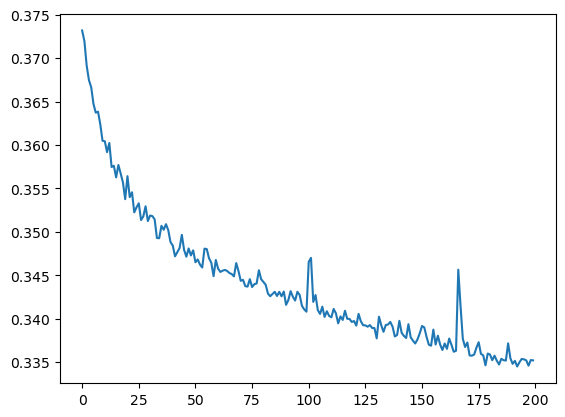

In [77]:
avg_loss.extend(average_loss)
plt.plot(avg_loss)

In [101]:
def update_average_loss(avg_loss, average_loss):
    avg_loss.extend(average_loss)
    plt.plot(avg_loss)
    return avg_loss

In [83]:
set_test(current_checkpoint=200)

Using downloaded and verified file: ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar
Extracting ../data/pascal_voc_dataset/validation/VOCtrainval_11-May-2012.tar to ../data/pascal_voc_dataset/validation


100%|██████████| 138/138 [00:24<00:00,  5.71it/s]

Test finished.


In [97]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def test_predicted_image(index: int, checkpoint: int):
    """ Display the image, ground truth mask, and predicted mask. """
    
    image = torch.load(f'../rsc/test/image_{index}.pth')
    output = torch.load(f'../rsc/ntest200/output_{index}.pth')
    mask = torch.load(f'../rsc/test/mask_{index}.pth')

    image.shape, output.shape, mask.shape

    # Select a specific image from the batch (e.g., the first image)
    image_single = image[0]
    output_single = output[0].argmax(dim=0, keepdim=True)
    mask_single = mask[0]

    # Scale the output and mask tensors to the range [0, 255]
    output_single_scaled = (output_single * 255).to(torch.uint8)
    mask_single_scaled = (mask_single * 255).to(torch.uint8)

    # Convert the single image and scaled tensors to PIL images
    image_pil = transforms.ToPILImage()(image_single.cpu())
    output_pil = transforms.ToPILImage()(output_single_scaled.cpu().squeeze())
    mask_pil = transforms.ToPILImage()(mask_single_scaled.cpu().squeeze())

    # Create a grid of subplots
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    # Plot the images in the subplots
    axes[0].imshow(image_pil)
    axes[0].set_title('Image')
    axes[0].axis('off')

    axes[1].imshow(output_pil)
    axes[1].set_title('Output')
    axes[1].axis('off')

    axes[2].imshow(mask_pil)
    axes[2].set_title('Mask')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

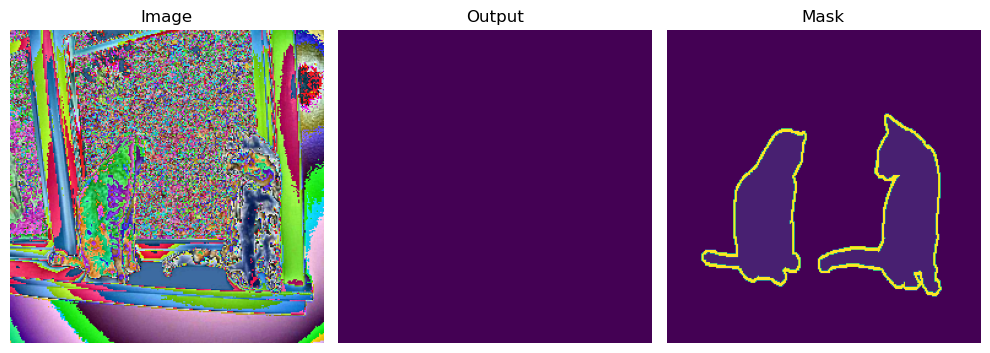

In [104]:
test_predicted_image(38, 200)

In [95]:
import torch
from tqdm import tqdm

def calculate_iou(outputs, masks):
    outputs = torch.argmax(outputs, dim=1)
    masks = masks.squeeze()
    
    # Move tensors to the same device
    device = outputs.device
    masks = masks.to(device)
    
    intersection = torch.logical_and(outputs, masks).sum().item()
    union = torch.logical_or(outputs, masks).sum().item()
    
    iou = intersection / union
    return iou


def calculate_average_iou(checkpoint: int):
    iou_scores = {}
    for i in tqdm(range(1, len(test_loader)+1)):
        
        outputs = torch.load(f'../rsc/ntest{checkpoint}/output_{i}.pth')
        masks = torch.load(f'../rsc/test/mask_{i}.pth')

        # Calculate IoU score
        iou = calculate_iou(outputs, masks)
        iou_scores[i] = iou

    print("\nAverage IoU:", sum(iou_scores.values()) / len(iou_scores))

In [96]:
calculate_average_iou(200)

100%|██████████| 138/138 [00:00<00:00, 358.95it/s]


Average IoU: 0.0


In [110]:
import multiprocessing
from torch.utils.data import DataLoader


def training_loop(model, current_checkpoint: int, num_epochs: int):
    """ Training loop. """
    #model = deeplabv3_resnet50(weight=True)

    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Set the number of CPU cores to use
    num_cpu = multiprocessing.cpu_count()

    print(f"Device in use: {device}")

    # Move the model to the device
    model = model.to(device)

    # Wrap the model with DataParallel if multiple GPUs or CPUs are available
    if torch.cuda.device_count() >= 1:
        print(f"Using {torch.cuda.device_count()} GPUs.")
        model = nn.DataParallel(model)
    elif num_cpu > 1:
        print(f"Using {num_cpu} CPU cores.")
        model = nn.DataParallel(model)
    else:
        print("Using single CPU.")
        
    # Define the loss function
    #criterion = nn.CrossEntropyLoss()

    # Define the optimizer
    #optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Set the model to training mode
    model.train()

    # Define the data loader
    #train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)  # Adjust batch_size and other parameters

    #train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, shuffle=True)
    #val_loader = torch.utils.data.DataLoader(val_set, batch_size=8)
    #test_loader = torch.utils.data.DataLoader(test_set, batch_size=8)

    # Define the number of epochs
    #num_epochs = 100

    # Define the average loss list
    average_loss = []

    # Training loop
    for epoch in range(1, num_epochs + 1):
        running_loss = 0.0
        for images, masks in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch}/{num_epochs}", miniters=1, position=0):
            # Move data to the device
            images = images.to(device)
            masks = masks.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            #outputs = model(images)['out']
            outputs = model(images)

            # Calculate the loss
            #loss = criterion(outputs, masks.squeeze(1).long())
            loss = criterion(outputs, masks.unsqueeze(1).float().squeeze(2))


            # Backward pass
            loss.backward()

            # Update the weights
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Print the average loss for the given epoch
        average_loss.append(running_loss / len(train_loader))
        # saving every 10 epochs
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"n_modelo_{current_checkpoint+epoch}.pth")
            print(f"Model saved: modelo_{current_checkpoint+epoch}.pth")

In [ ]:
training_loop(model, 200, 100)